# REALTIME FACEMASK DETECTION: CREATING AND TRAINING THE MODEL 

In [18]:
# importing all necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import os
from imutils import paths
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import utils
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# Defining various parameters

PATH_TO_TRAINING_DATASET = './Dataset/train'
PATH_TO_TESTING_DATASET = './Dataset/test'
INITIAL_LEARNING_RATE = 0.0001
EPOCHS = 20
BATCH_SIZE = 32

In [3]:
# Create a list of the paths of all images in the training dataset
training_image_paths = list(paths.list_images(PATH_TO_TRAINING_DATASET))
print('Number of images for training: ', len(training_image_paths))


# Create a list of the paths of all images in the testing dataset
testing_image_paths = list(paths.list_images(PATH_TO_TESTING_DATASET))
print('Number of images for testing: ', len(testing_image_paths))

Number of images for training:  1914
Number of images for testing:  500


In [4]:
trainX = []  # Container to store all training images
trainY = []  # Container to store the categories/labels of the training images

# loop over the training image paths
for i in range(len(training_image_paths)):
    
    # Get the path of the current image
    image_path = training_image_paths[i]
    
    # Load the image (224 x 224) and preprocess it
    image = Image.load_img(image_path, target_size=(224, 224))
    image = Image.img_to_array(image)
    image = preprocess_input(image)
    trainX.append(image)
    
    # extract the class label/category from the filename
    category = image_path.split(os.path.sep)[-2]
    trainY.append(category)
    
# Convert the lists into numpy arrays
trainX = np.array(trainX, dtype = 'float32')
trainY = np.array(trainY)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

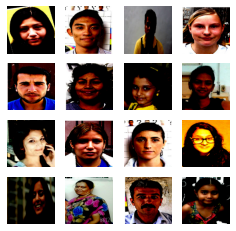

In [5]:
# Preview of training dataset (first 16 images)
fig = plt.figure(figsize=(4,4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(trainX[i])
    plt.axis('off')

plt.show()

In [6]:
testX = []  # Container to store all testing images
testY = []  # Container to store the categories/labels of the testing images

# loop over the testing image paths
for i in range(len(testing_image_paths)):
    
    # Get the path of the current image
    image_path = testing_image_paths[i]
    
    # Load the image (224 x 224) and preprocess it
    image = Image.load_img(image_path, target_size=(224, 224))
    image = Image.img_to_array(image)
    image = preprocess_input(image)
    testX.append(image)
    
    # extract the class label/category from the filename
    category = image_path.split(os.path.sep)[-2]
    testY.append(category)

# Convert the lists into numpy arrays
testX = np.array(testX, dtype = 'float32')
testY = np.array(testY)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

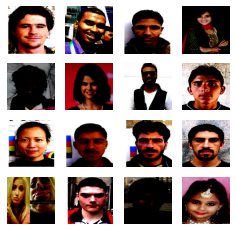

In [7]:
# Preview of testing dataset (first 16 images)
fig = plt.figure(figsize=(4,4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(testX[i])
    plt.axis('off')

plt.show()

In [8]:
# One hot encoding of the labels
labelBinariser = LabelBinarizer()

trainY = labelBinariser.fit_transform(trainY)
trainY = utils.to_categorical(trainY)
print(trainY[:5])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [9]:
# One hot encoding of the labels
testY = labelBinariser.fit_transform(testY)
testY = utils.to_categorical(testY)
print(testY[:5])


# [0, 1] = Without Mask
# [1, 0] = With Mask

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [10]:
# Performing data augmentation
# In data augmentation, each image that is fed into the model will undergo random changes like rotation, zoom, flips ets.
# This increases the variance in the dataset and thus enhances the performance of the model 

augmented_data = Image.ImageDataGenerator(
                width_shift_range=0.2,
                height_shift_range=0.2,
                rotation_range=20,
                zoom_range=0.15,
                shear_range=0.15,
                horizontal_flip=True,
                fill_mode="nearest")

In [11]:
# MODEL

# Using Mobilenetv2 architecture by excluding the top layer for transfer learning
mobilenetv2 = MobileNetV2(input_shape = (224,224,3), include_top = False, weights = 'imagenet')
mobilenetv2.trainable = False

# Custom model
model = Sequential()
model.add(mobilenetv2)
model.add(GlobalAveragePooling2D())
model.add(DenDensese(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,340,098
Trainable params: 82,114
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
# Using ADAM optimiser
adam_optimiser = Adam(lr = INITIAL_LEARNING_RATE, decay = INITIAL_LEARNING_RATE / EPOCHS)

# Compiling Model
model.compile(loss="binary_crossentropy", optimizer=adam_optimiser, metrics=["accuracy"])

In [13]:
# Start the training of the model

History = model.fit(
            augmented_data.flow(trainX, trainY, batch_size = BATCH_SIZE),
            steps_per_epoch=len(trainX) // BATCH_SIZE,
            validation_data=(testX, testY),
            validation_steps=len(testX) // BATCH_SIZE,
            epochs=EPOCHS)

Epoch 1/20
59/59 [==============================] - 75s 1s/step - loss: 0.4392 - accuracy: 0.7965 - val_loss: 0.1768 - val_accuracy: 0.9320
Epoch 2/20
59/59 [==============================] - 79s 1s/step - loss: 0.1433 - accuracy: 0.9532 - val_loss: 0.1051 - val_accuracy: 0.9560
Epoch 3/20
59/59 [==============================] - 75s 1s/step - loss: 0.0875 - accuracy: 0.9702 - val_loss: 0.0807 - val_accuracy: 0.9720
Epoch 4/20
59/59 [==============================] - 75s 1s/step - loss: 0.0690 - accuracy: 0.9772 - val_loss: 0.0681 - val_accuracy: 0.9800
Epoch 5/20
59/59 [==============================] - 74s 1s/step - loss: 0.0615 - accuracy: 0.9772 - val_loss: 0.0491 - val_accuracy: 0.9840
Epoch 6/20
59/59 [==============================] - 76s 1s/step - loss: 0.0486 - accuracy: 0.9835 - val_loss: 0.0482 - val_accuracy: 0.9820
Epoch 7/20
59/59 [==============================] - 75s 1s/step - loss: 0.0462 - accuracy: 0.9825 - val_loss: 0.0494 - val_accuracy: 0.9820
Epoch 8/20
59/59 [==

In [14]:
# make predictions on the testing set
print("MODEL EVALUATION")

# Using the test dataset to perform prediction with the created model
predictions = model.predict(testX, batch_size=BATCH_SIZE)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
prediction_indexes = np.argmax(predictions, axis=1)

correct_indexes = testY.argmax(axis=1)

# classification report
# The predicted class for each image is checked against its actual class to evaluate the model
print(classification_report(correct_indexes, prediction_indexes, target_names=labelBinariser.classes_))

MODEL EVALUATION
              precision    recall  f1-score   support

   with_mask       1.00      0.98      0.99       250
without_mask       0.98      1.00      0.99       250

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



In [15]:
# save the model

model.save('mask_detector_model.h5', save_format="h5")

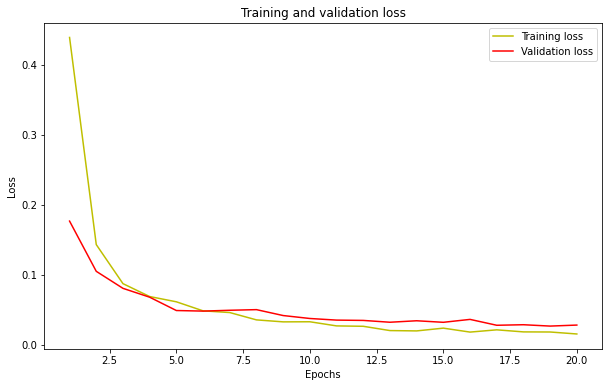

In [19]:
# Plotting the loss during training and validation

loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

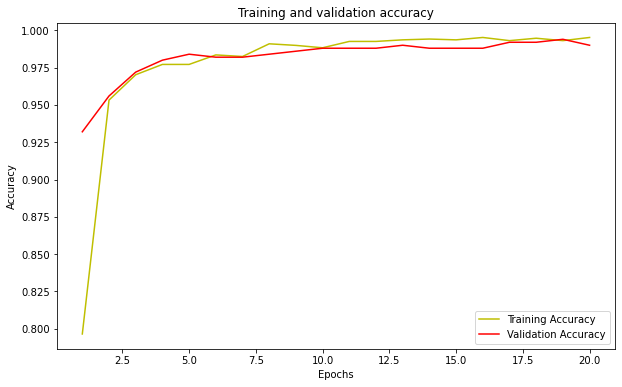

In [20]:
# Plotting the accuracy during training and validation

acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

plt.plot(epochs, acc, 'y', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()